Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
144/144 [==============================] - 3s 7ms/step - loss: 0.0350
Epoch 2/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0239
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0204
Epoch 4/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0127
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0096
Epoch 6/50
144/144 [======================

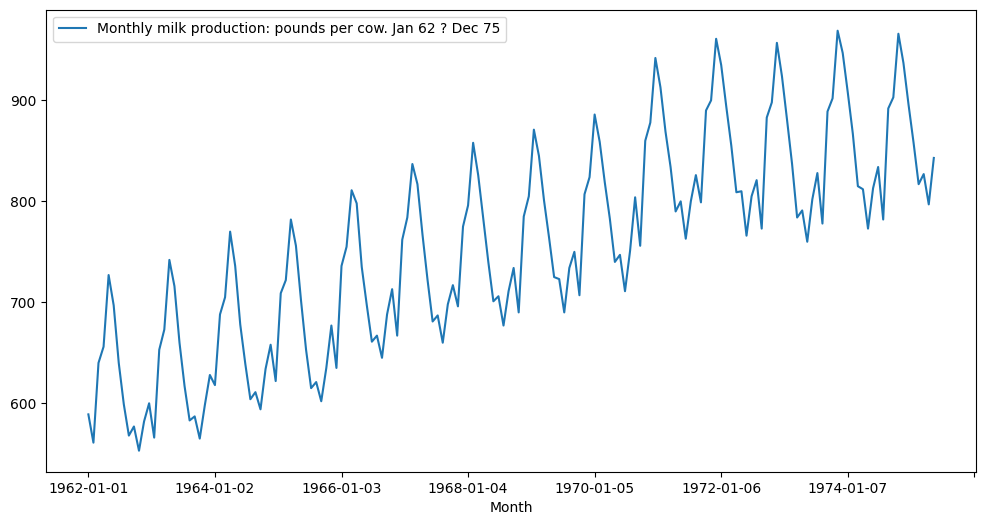

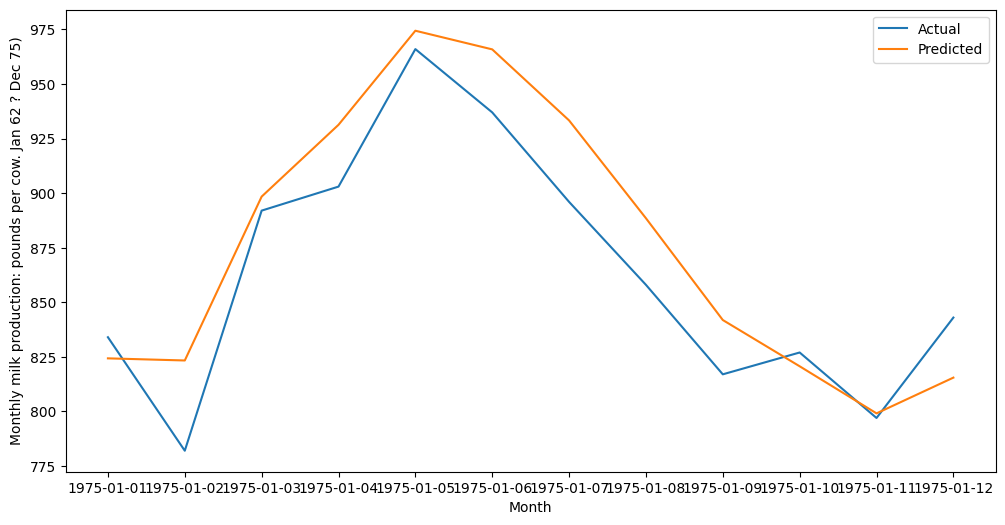

RMSE: 24.654809426144187


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Read the dataset
df = pd.read_csv('/content/monthlyMilkProduction.csv')

# Extract the 'monthly milk production pounds per cow' column for scaling
data = df['Monthly milk production: pounds per cow. Jan 62 ? Dec 75'].values.astype(float)

# Extract the 'month' column for date information
dates = df['Month']

# Plot the dataset
df.plot(x='Month', y='Monthly milk production: pounds per cow. Jan 62 ? Dec 75', figsize=(12, 6))

# Split the dataset into training and testing
train = data[:156]
test = data[156:]

# Reshape the data to have a single feature and multiple samples
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

# Preprocess the data to convert the dataset into a scale of 0 to 1
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Define generator
n_input = 12
n_features = 1

# Correct the typo 'lenght' to 'length' in the TimeseriesGenerator
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# Define the model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

# Fit the model
model.fit(generator, epochs=50)

# Prepare the last training batch for prediction
last_train_batch = scaled_train[-n_input:].reshape((1, n_input, n_features))

# Initialize a list for test predictions
test_predictions = []

# Predict values for each point in the test set
for i in range(len(test)):
    current_pred = model.predict(last_train_batch)[0, 0]
    test_predictions.append(current_pred)
    last_train_batch = np.append(last_train_batch[:, 1:, :], [[[current_pred]]], axis=1)  # Add an extra square bracket

# Inverse transform the scaled predictions to the original scale
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Create a new DataFrame for predictions
predictions_df = pd.DataFrame({'Month': dates[156:], 'predictions': true_predictions.flatten()})

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(dates[156:], test, label='Actual')
plt.plot(dates[156:], true_predictions, label='Predicted')
plt.xlabel('Month')
plt.ylabel('Monthly milk production: pounds per cow. Jan 62 ? Dec 75)')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, true_predictions))
print(f"RMSE: {rmse}")
